# Python and Data Imports

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [19]:
df = pd.read_parquet('../data/cleaned/sp500.parquet')
# df = df[0:1500]
df = df[['Date', 'Close', 'LogRet']]
df

,Date,Close,LogRet
0,2005-09-20,1221.339966,-0.007895
1,2005-09-21,1210.199951,-0.009163
2,2005-09-22,1214.619995,0.003646
3,2005-09-23,1215.290039,0.000551
4,2005-09-26,1215.630005,0.000280
...,...,...,...
5025,2025-09-11,6587.470215,0.008450
5026,2025-09-12,6584.290039,-0.000483
5027,2025-09-15,6615.279785,0.004696
5028,2025-09-16,6606.759766,-0.001289


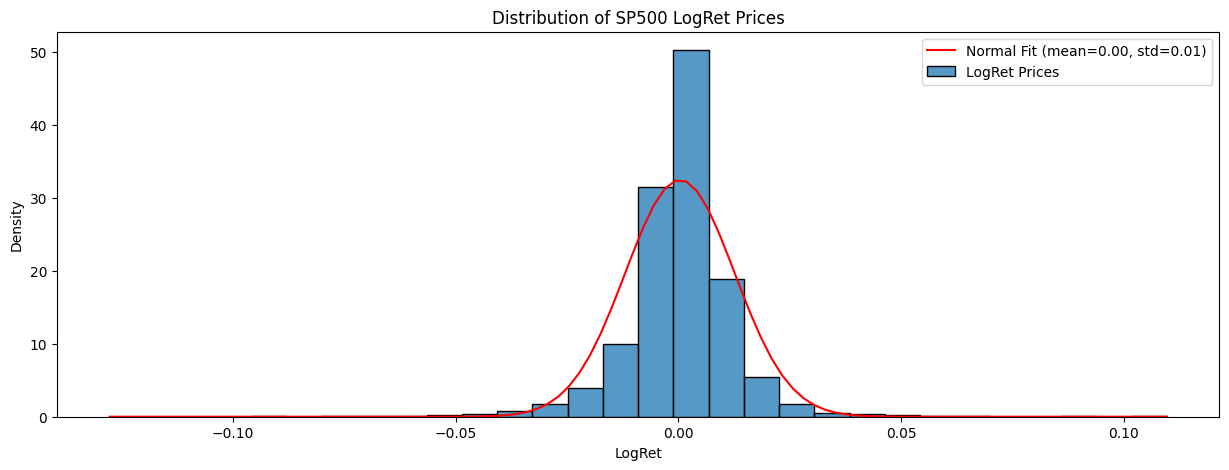

In [20]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt
df.dropna(inplace=True)
# Plot histogram of Close prices
plt.figure(figsize=(15, 5))
sns.histplot(df['LogRet'], kde=False, stat="density", bins=30, label='LogRet Prices')

# Fit a normal distribution to the data
mean, std = norm.fit(df['LogRet'])
x = np.linspace(df['LogRet'].min(), df['LogRet'].max(), 100)
pdf = norm.pdf(x, mean, std)

# Plot the normal distribution curve
plt.plot(x, pdf, 'r-', label=f'Normal Fit (mean={mean:.2f}, std={std:.2f})')
plt.title('Distribution of SP500 LogRet Prices')
plt.legend()
plt.show()

## Stationarity analysis

In [21]:

from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.4f}")
    print(f"p-value: {adf_result[1]:.4f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.4f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.4f}")
    print(f"p-value: {kpss_result[1]:.4f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.4f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

# stationarity_analysis(df=df, dataset_name="S&P500_raw")
# stationarity_analysis(df=df, dataset_name="S&P500_log_returns", column_name='LogRet')

In [22]:
features = ['LogRet']
X = df[features].values[:-1]  # All but last
y = df['LogRet'].values[1:]  # All but first (shifted by +1)

## PyTorch SRNNs

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit  # For guidance, but implementing custom rolling for financial data
torch.manual_seed(42)

# Step 1: Define Elman RNN Model
class ElmanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(ElmanRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

# Step 2: Custom Dataset for Sequences
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, seq_len=10):
        self.data = data
        self.targets = targets
        self.seq_len = seq_len
    
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx + self.seq_len]
        y = self.targets[idx + self.seq_len]
        return torch.FloatTensor(x), torch.FloatTensor([y])

class JordanRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Jordan RNN Model. The num_layers parameter is kept for API consistency
        but this implementation uses a single hidden layer.
        """
        super(JordanRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # The RNN cell takes the input and the combined hidden+previous_output state
        self.rnn_cell = nn.RNNCell(input_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.fc.out_features).to(x.device)

        for t in range(seq_len):
            # Use previous timestep's output
            combined_input = torch.cat((x[:, t, :], prev_output), dim=1)
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Compute current output
            current_output = self.fc(hidden)
            
            # Update prev_output for NEXT iteration
            prev_output = current_output
            
        return current_output
    
class MultiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Multi-Recurrent Neural Network (MultiRNN) - Combination of Elman and Jordan RNNs
        
        This network feeds back both:
        1. Previous hidden state (like Elman RNN)
        2. Previous output (like Jordan RNN)
        
        Args:
            input_size: Number of input features
            hidden_size: Number of hidden units
            output_size: Number of output features
            num_layers: Number of layers (kept for API consistency, uses single layer)
        """
        super(MultiRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        # The RNN cell takes input + previous_hidden + previous_output
        # Input concatenation: [current_input, prev_hidden, prev_output]
        self.rnn_cell = nn.RNNCell(input_size + hidden_size + output_size, hidden_size)
        
        # Fully connected layer to produce the output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Forward pass through the MultiRNN
        
        Args:
            x: Input tensor of shape (batch_size, seq_len, input_size)
            
        Returns:
            Output tensor of shape (batch_size, output_size)
        """
        # Get batch size and sequence length
        batch_size = x.size(0)
        seq_len = x.size(1)
        
        # Initialize hidden state and output for the first time step
        hidden = torch.zeros(batch_size, self.hidden_size).to(x.device)
        prev_output = torch.zeros(batch_size, self.output_size).to(x.device)

        # Manually loop through each time step in the sequence
        for t in range(seq_len):
            # Concatenate current input, previous hidden state, and previous output
            # This is the key difference: we use BOTH prev_hidden and prev_output
            combined_input = torch.cat((x[:, t, :], hidden, prev_output), dim=1)
            
            # Update the hidden state using the combined input
            hidden = self.rnn_cell(combined_input, hidden)
            
            # Calculate the current output based on the new hidden state
            current_output = self.fc(hidden)
            
            # Update prev_output for the next time step
            prev_output = current_output
            
        # Return the final output (output from the last time step)
        return current_output


## Model parameters and train validation test splitting

In [24]:

# Parameters
seq_len = 15
batch_size = 64
num_layers = 1
epochs = 100
n_folds = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = 1
output_size = 1

# --- New: one overarching train/holdout split at the beginning (holdout is the last chunk of the series)
holdout_ratio = 0.3  # fraction kept for final test at the end
n_total = len(X)
holdout_size = int(holdout_ratio * n_total)

# Training and validation portion
X_trainval = X[:-holdout_size]
y_trainval = y[:-holdout_size]

# Held out portion
X_holdout = X[-holdout_size:]
y_holdout = y[-holdout_size:]

# --- Clamp outliers based ONLY on the training data statistics to prevent data leakage ---
CLAMP_STD = 3
# Calculate mean and standard deviation from the training/validation set only
mean_X = X_trainval.mean()
std_X = X_trainval.std()

# Define the upper and lower bounds
lower_bound = mean_X - CLAMP_STD * std_X
upper_bound = mean_X + CLAMP_STD * std_X

# Clamp both the training/validation set and the holdout set using the training statistics
X_trainval = np.clip(X_trainval, lower_bound, upper_bound)

# --- Growing-window CV on the training+validation portion
results = {'fold': [], 'rmse': [], 'mae': []}

n_trainval = len(X_trainval)
# initial training window inside trainval (choose a sensible starting window)
initial_train_ratio = 0.5
initial_train_window = max(int(initial_train_ratio * n_trainval), seq_len + 1)
remaining = n_trainval - initial_train_window
if remaining < n_folds:  # ensure at least one sample per test fold
    raise ValueError("Not enough data in training portion to create the requested number of folds. Reduce n_folds or holdout_ratio.")

fold_test_size = max(1, remaining // n_folds)

### Gridsearch CV

In [25]:
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error


def gridsearchCV_RNNs(model_to_use='Elman'):

    # Step 1: Define the grid of hyperparameters to search over
    param_grid = {
        'hidden_size': range(32, 97, 32),
        'learning_rate': [0.00001, 0.0001, 0.0005, 0.001],
        'seq_len': range(10, 31, 15),
        'weight_decay': [1e-5, 1e-4, 1e-3],  # Add this line
        'patience': [10]  # Add this line
    }

    # --- Store results for each parameter combination ---
    grid_search_results = []
    keys, values = zip(*param_grid.items())

    # Step 2: Outer loop for Grid Search
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        
        # Unpack current hyperparameters
        hidden_size = params['hidden_size']
        learning_rate = params['learning_rate']
        seq_len = params['seq_len']
        weight_decay = params['weight_decay']
        patience = params['patience']
        
        # You can unpack others like batch_size here if you add them to the grid
        
        print(f"\n{'='*60}")
        print(f"TESTING HYPERPARAMETERS: {params}")
        print(f"{'='*60}")
        
        # Store results for the folds of this specific parameter set
        current_param_fold_results = {'rmse': [], 'mae': []}

        # Step 3: Inner loop for Growing-Window Cross-Validation
        for fold in range(n_folds):
            train_start = 0
            train_end = initial_train_window + fold * fold_test_size
            test_start = train_end
            test_end = min(test_start + fold_test_size, n_trainval)

            # Ensure there's enough data
            if train_end - train_start < seq_len + 1 or test_end - test_start < seq_len + 1:
                print(f"Skipping fold {fold}: Insufficient data for seq_len={seq_len}")
                continue

            # Extract fold data
            X_tr, y_tr = X_trainval[train_start:train_end], y_trainval[train_start:train_end]
            X_te, y_te = X_trainval[test_start:test_end], y_trainval[test_start:test_end]

            # Split training data into train/validation for early stopping
            val_split = 0.2
            train_split_idx = int(len(X_tr) * (1 - val_split))
            
            X_train_fold = X_tr[:train_split_idx]
            y_train_fold = y_tr[:train_split_idx]
            X_val_fold = X_tr[train_split_idx:]
            y_val_fold = y_tr[train_split_idx:]

            # Scale data
            scaler_X = StandardScaler().fit(X_train_fold)  # Fit only on training portion
            X_train_scaled = scaler_X.transform(X_train_fold)
            X_val_scaled = scaler_X.transform(X_val_fold)
            X_te_scaled = scaler_X.transform(X_te)
            
            scaler_y = StandardScaler().fit(y_train_fold.reshape(-1, 1))
            y_train_scaled = scaler_y.transform(y_train_fold.reshape(-1, 1)).flatten()
            y_val_scaled = scaler_y.transform(y_val_fold.reshape(-1, 1)).flatten()
            y_te_scaled = scaler_y.transform(y_te.reshape(-1, 1)).flatten()

            # Create datasets & loaders
            train_dataset = TimeSeriesDataset(X_train_scaled, y_train_scaled, seq_len)
            val_dataset = TimeSeriesDataset(X_val_scaled, y_val_scaled, seq_len)
            test_dataset = TimeSeriesDataset(X_te_scaled, y_te_scaled, seq_len)
            
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

            # Initialize model
            if model_to_use == 'Jordan':
                model = JordanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Elman':
                model = ElmanRNN(input_size, hidden_size, output_size, num_layers).to(device)
            elif model_to_use == 'Multi':
                model = MultiRNN(input_size, hidden_size, output_size, num_layers).to(device)
            
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

            # Training with Early Stopping
            best_val_loss = float('inf')
            patience_counter = 0
            best_model_state = None
            
            for epoch in range(epochs):
                # Training phase
                model.train()
                for batch_x, batch_y in train_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_x)
                    loss = criterion(outputs.squeeze(), batch_y)
                    loss.backward()
                    optimizer.step()

                # Validation phase (after each epoch)
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_x, batch_y in val_loader:
                        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                        outputs = model(batch_x)
                        val_loss += criterion(outputs.squeeze(), batch_y).item()
                
                val_loss /= len(val_loader)

                # Early stopping check
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience_counter = 0
                    best_model_state = model.state_dict().copy()  # Save best model state
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} for fold {fold}")
                    break
            
            # Load best model for evaluation
            if best_model_state is not None:
                model.load_state_dict(best_model_state)

            # Evaluation on the actual test set (unseen during training/validation)
            model.eval()
            predictions = []
            with torch.no_grad():
                for batch_x, _ in test_loader:  # Use test_loader, not val_loader
                    batch_x = batch_x.to(device)
                    outputs = model(batch_x)
                    predictions.extend(outputs.squeeze().cpu().numpy())

            predictions = np.array(predictions)
            true_y = y_te_scaled[seq_len:]
            predictions = predictions[:len(true_y)]

            rmse = np.sqrt(mean_squared_error(true_y, predictions))
            mae = mean_absolute_error(true_y, predictions)

            current_param_fold_results['rmse'].append(rmse)
            current_param_fold_results['mae'].append(mae)

        # After all folds for the current param set are done, calculate the average score
        if current_param_fold_results['rmse']: # Check if any folds ran
            mean_rmse = np.mean(current_param_fold_results['rmse'])
            mean_mae = np.mean(current_param_fold_results['mae'])
            
            # print(f"\n--- Avg CV Score for {params}: RMSE = {mean_rmse:.4f}, MAE = {mean_mae:.4f} ---")
            
            grid_search_results.append({
                'params': params,
                'mean_rmse': mean_rmse,
                'mean_mae': mean_mae
            })

    # Step 4: Find and print the best hyperparameter combination
    if grid_search_results:
        best_params_result = min(grid_search_results, key=lambda x: x['mean_rmse'])
        print(f"\n{'='*60}")
        print("GRID SEARCH COMPLETE for model:", model_to_use)
        print(f"Best Hyperparameters found: {best_params_result['params']}")
        print(f"Best Mean CV RMSE: {best_params_result['mean_rmse']:.4f}")
        print(f"{'='*60}")
        return best_params_result
    else:
        print("\nGrid search did not complete. Check data size and parameters.")

In [26]:
from sklearn.impute import SimpleImputer

Xh = X_holdout  # numpy array from your code
print("shape:", Xh.shape)
print("any inf:", np.isinf(Xh).any())
print("any nan:", np.isnan(Xh).any())
finite_mask = np.isfinite(Xh)
print("finite all?:", finite_mask.all())
# extremes
finite_vals = Xh[finite_mask]
print("max abs finite value:", np.nan if finite_vals.size==0 else np.max(np.abs(finite_vals)))
# if you still use df/feature names:
Xh_df = pd.DataFrame(Xh, columns=features)
print(Xh_df.replace([np.inf, -np.inf], np.nan).isna().sum())

# convert inf -> nan
X_trainval = np.where(np.isfinite(X_trainval), X_trainval, np.nan)
X_holdout  = np.where(np.isfinite(X_holdout),  X_holdout,  np.nan)

# impute (median is robust)
imp = SimpleImputer(strategy="median")
X_trainval = imp.fit_transform(X_trainval)
X_holdout  = imp.transform(X_holdout)

shape: (1508, 1)
any inf: False
any nan: False
finite all?: True
max abs finite value: 0.12765219747281742
LogRet    0
dtype: int64


# Final Testing

### Preparing final testing data

In [27]:


# Final: retrain on entire trainval and evaluate once on the held-out end-of-series test set
# Fit scalers on whole trainval
scaler_X_full = StandardScaler().fit(X_trainval)
X_trainval_scaled = scaler_X_full.transform(X_trainval)
X_holdout_scaled = scaler_X_full.transform(X_holdout)

scaler_y_full = StandardScaler().fit(y_trainval.reshape(-1, 1))
y_trainval_scaled = scaler_y_full.transform(y_trainval.reshape(-1, 1)).flatten()
y_holdout_scaled = scaler_y_full.transform(y_holdout.reshape(-1, 1)).flatten()


# Final Elman

In [28]:

# Store results separately
elman_params = {'hidden_size': 32, 'learning_rate': 1e-05, 'seq_len': 10, 'weight_decay': 0.0001, 'patience': 10}
jordan_params =  {'hidden_size': 32, 'learning_rate': 1e-05, 'seq_len': 10, 'weight_decay': 0.001, 'patience': 10}
multi_params = {'hidden_size': 32, 'learning_rate': 1e-05, 'seq_len': 10, 'weight_decay': 0.0001, 'patience': 10}



In [29]:
# Create separate final models for each architecture
print("Training Elman RNN...")
final_model_elman = ElmanRNN(input_size, elman_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=elman_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=elman_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Elman
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_elman.parameters(), lr=elman_params['learning_rate'], weight_decay=elman_params['weight_decay'])
final_model_elman.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_elman(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Elman predictions
final_model_elman.eval()
elman_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_elman(batch_x)
        elman_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

elman_predictions = np.array(elman_predictions)
elman_y_pred_inv = scaler_y_full.inverse_transform(elman_predictions.reshape(-1, 1)).flatten()

print("Training Jordan RNN...")
final_model_jordan = JordanRNN(input_size, jordan_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=jordan_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=jordan_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Jordan
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_jordan.parameters(), lr=jordan_params['learning_rate'], weight_decay=jordan_params['weight_decay'])
final_model_jordan.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_jordan(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Jordan predictions
final_model_jordan.eval()
jordan_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_jordan(batch_x)
        jordan_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

jordan_predictions = np.array(jordan_predictions)
jordan_y_pred_inv = scaler_y_full.inverse_transform(jordan_predictions.reshape(-1, 1)).flatten()

print("Training Multi RNN...")
final_model_multi = MultiRNN(input_size, multi_params['hidden_size'], output_size, num_layers).to(device)
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled, seq_len=multi_params['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled, seq_len=multi_params['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train Multi
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model_multi.parameters(), lr=multi_params['learning_rate'], weight_decay=multi_params['weight_decay'])
final_model_multi.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model_multi(batch_x)
        loss = criterion(outputs.squeeze(-1), batch_y.squeeze(-1))
        loss.backward()
        optimizer.step()

# Get Multi predictions
final_model_multi.eval()
multi_predictions = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model_multi(batch_x)
        multi_predictions.extend(np.atleast_1d(outputs.squeeze().cpu().numpy()))

multi_predictions = np.array(multi_predictions)
multi_y_pred_inv = scaler_y_full.inverse_transform(multi_predictions.reshape(-1, 1)).flatten()

Training Elman RNN...
Training Jordan RNN...
Training Multi RNN...



Model Comparison (Log Returns):
Elman RNN - RMSE: 0.0133, MAE: 0.0086
Jordan RNN - RMSE: 0.0132, MAE: 0.0085
Multi RNN - RMSE: 0.0134, MAE: 0.0086

Model Comparison (Reconstructed Closing Prices):
Elman RNN - RMSE: 54.191012, MAE: 36.0132, MAPE: 0.86%
Jordan RNN - RMSE: 53.925330, MAE: 35.9141, MAPE: 0.86%
Multi RNN - RMSE: 54.480714, MAE: 36.1096, MAPE: 0.86%


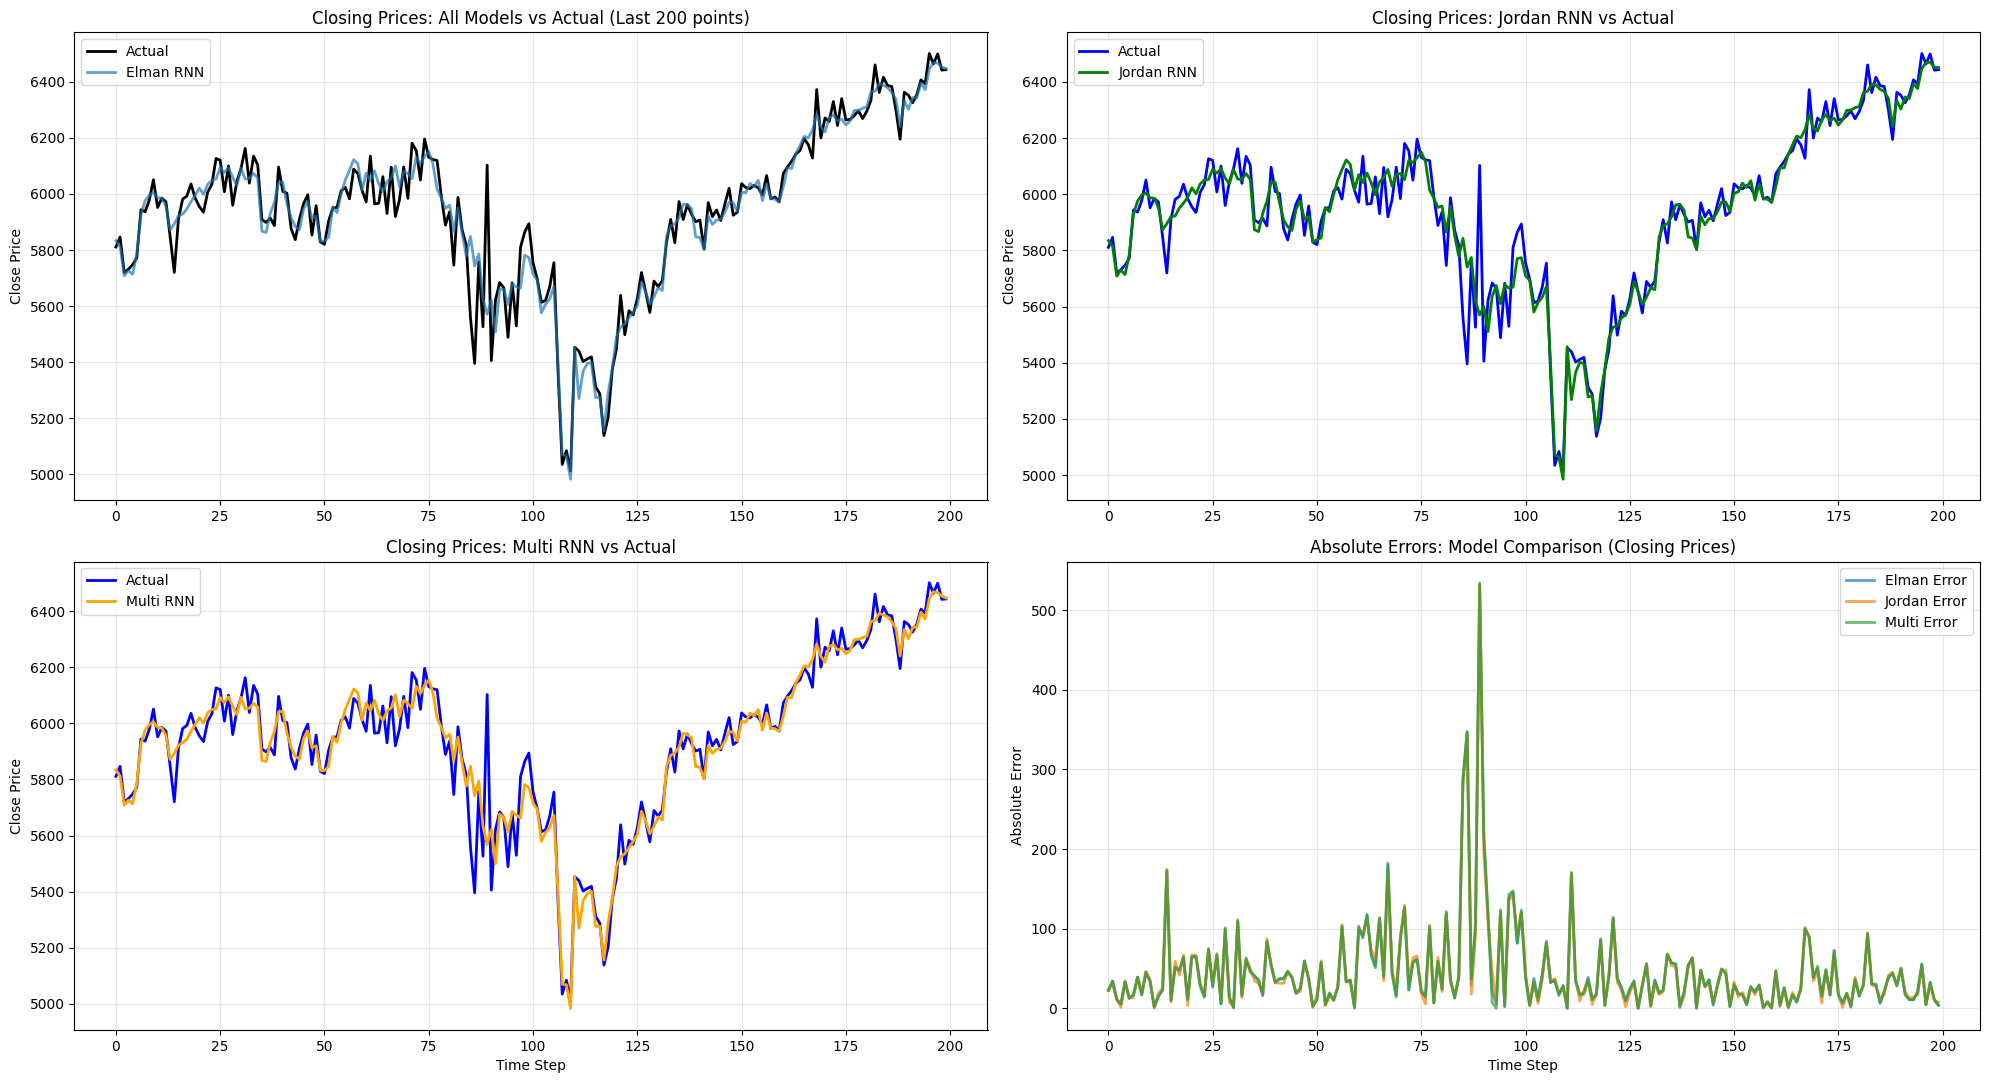

In [30]:
# Get true values for comparison
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        true_vals.extend(batch_y.numpy().flatten())

true_y = np.array(true_vals)
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()

# Calculate metrics for all models
models_results = {
    'Elman': {
        'predictions': elman_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, elman_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, elman_y_pred_inv)
    },
    'Jordan': {
        'predictions': jordan_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, jordan_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, jordan_y_pred_inv)
    },
    'Multi': {
        'predictions': multi_y_pred_inv,
        'rmse': np.sqrt(mean_squared_error(y_true_inv, multi_y_pred_inv)),
        'mae': mean_absolute_error(y_true_inv, multi_y_pred_inv)
    }
}

# Print comparison
print("\nModel Comparison (Log Returns):")
print("=" * 50)
for model_name, results in models_results.items():
    print(f"{model_name} RNN - RMSE: {results['rmse']:.4f}, MAE: {results['mae']:.4f}")

# Get the actual closing prices corresponding to the holdout period
holdout_start_idx = len(df) - len(y_holdout) - elman_params['seq_len']

# Function to reconstruct prices using actual historical prices as base
def reconstruct_prices_with_actual_base(log_returns_pred, log_returns_actual, base_prices):
    """
    Reconstruct closing prices using actual historical prices as base
    """
    predicted_prices = np.zeros_like(log_returns_pred)
    actual_prices = np.zeros_like(log_returns_actual)
    
    for i in range(len(log_returns_pred)):
        if i < len(base_prices) - 1:
            # Use actual historical price as base
            base_price = base_prices[i]
        else:
            # Use the last actual price we have
            base_price = base_prices[-1]
            
        predicted_prices[i] = base_price * np.exp(log_returns_pred[i])
        actual_prices[i] = base_price * np.exp(log_returns_actual[i])
    
    return predicted_prices, actual_prices

# Get base prices for reconstruction
extended_base_prices = df['Close'].iloc[holdout_start_idx-1:holdout_start_idx + len(y_true_inv)].values

# Reconstruct closing prices for all models
elman_prices, actual_prices = reconstruct_prices_with_actual_base(
    elman_y_pred_inv, y_true_inv, extended_base_prices
)

jordan_prices, _ = reconstruct_prices_with_actual_base(
    jordan_y_pred_inv, y_true_inv, extended_base_prices
)

multi_prices, _ = reconstruct_prices_with_actual_base(
    multi_y_pred_inv, y_true_inv, extended_base_prices
)

# Calculate price-based metrics
price_results = {
    'Elman': {
        'prices': elman_prices,
        'rmse': np.sqrt(mean_squared_error(actual_prices, elman_prices)),
        'mae': mean_absolute_error(actual_prices, elman_prices),
        'mape': np.mean(np.abs((actual_prices - elman_prices) / actual_prices)) * 100
    },
    'Jordan': {
        'prices': jordan_prices,
        'rmse': np.sqrt(mean_squared_error(actual_prices, jordan_prices)),
        'mae': mean_absolute_error(actual_prices, jordan_prices),
        'mape': np.mean(np.abs((actual_prices - jordan_prices) / actual_prices)) * 100
    },
    'Multi': {
        'prices': multi_prices,
        'rmse': np.sqrt(mean_squared_error(actual_prices, multi_prices)),
        'mae': mean_absolute_error(actual_prices, multi_prices),
        'mape': np.mean(np.abs((actual_prices - multi_prices) / actual_prices)) * 100
    }
}

print("\nModel Comparison (Reconstructed Closing Prices):")
print("=" * 60)
for model_name, results in price_results.items():
    print(f"{model_name} RNN - RMSE: {results['rmse']:.6f}, MAE: {results['mae']:.4f}, MAPE: {results['mape']:.2f}%")

# Extended plotting with both log returns and reconstructed prices
plt.figure(figsize=(20, 16))

# RECONSTRUCTED CLOSING PRICES PLOTS
# Plot 3: All models vs actual (Closing Prices)
plt.subplot(3, 2, 3)
plt.plot(actual_prices[-200:], label='Actual', linewidth=2, color='black')
plt.plot(elman_prices[-200:], label='Elman RNN', linewidth=2, alpha=0.7)
# plt.plot(jordan_prices[-200:], label='Jordan RNN', linewidth=2, alpha=0.7)
# plt.plot(multi_prices[-200:], label='Multi RNN', linewidth=2, alpha=0.7)
plt.title('Closing Prices: All Models vs Actual (Last 200 points)')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 4: Jordan vs Actual (Closing Prices)
plt.subplot(3, 2, 4)
plt.plot(actual_prices[-200:], label='Actual', linewidth=2, color='blue')
plt.plot(jordan_prices[-200:], label='Jordan RNN', linewidth=2, color='green')
plt.title('Closing Prices: Jordan RNN vs Actual')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Multi vs Actual (Closing Prices)
plt.subplot(3, 2, 5)
plt.plot(actual_prices[-200:], label='Actual', linewidth=2, color='blue')
plt.plot(multi_prices[-200:], label='Multi RNN', linewidth=2, color='orange')
plt.title('Closing Prices: Multi RNN vs Actual')
plt.ylabel('Close Price')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Error comparison across models (Closing Prices)
plt.subplot(3, 2, 6)
errors_elman = np.abs(actual_prices - elman_prices)
errors_jordan = np.abs(actual_prices - jordan_prices)
errors_multi = np.abs(actual_prices - multi_prices)

plt.plot(errors_elman[-200:], label='Elman Error', linewidth=2, alpha=0.7)
plt.plot(errors_jordan[-200:], label='Jordan Error', linewidth=2, alpha=0.7)
plt.plot(errors_multi[-200:], label='Multi Error', linewidth=2, alpha=0.7)
plt.title('Absolute Errors: Model Comparison (Closing Prices)')
plt.ylabel('Absolute Error')
plt.xlabel('Time Step')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../report/plots/rnn_model_comparison_spy.pdf')
plt.show()

In [31]:
# gridsearchCV_RNNs(model_to_use='Elman')

In [32]:
# gridsearchCV_RNNs(model_to_use='Jordan')

In [33]:
# gridsearchCV_RNNs(model_to_use='Multi')

# Old stuff

In [34]:
stop here

SyntaxError: invalid syntax (4067800170.py, line 1)

In [ ]:
# Initialize best_params_result so subsequent cells can update/use it without NameError
best_params_result = {
    'params': {
        'hidden_size': 150,
        'learning_rate': 0.02,
        'seq_len': 30,
        'weight_decay': 1e-05,
        'patience': 10
    },
    'mean_rmse': 50  # optional, from earlier grid search output
}

In [ ]:
# best_params_result = gridsearchCV_RNNs(model_to_use='Elman')

In [ ]:
# Train final model on entire trainval
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

final_model = ElmanRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.4f}, MAE = {mae_holdout_orig:.4f}")


In [ ]:
upuntill = 100

plt.figure(figsize=(12, 6))
plt.plot(y_true_inv[0:upuntill], label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_inv[0:upuntill], label='Predicted', linewidth=2, color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Holdout Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final Jordan

In [ ]:
best_params_result = gridsearchCV_RNNs(model_to_use='Jordan')

In [ ]:
# Train final model on entire trainval
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

final_model = JordanRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.4f}, MAE = {mae_holdout_orig:.4f}")


In [ ]:
upuntill = 100

plt.figure(figsize=(12, 6))
plt.plot(y_true_inv[0:upuntill], label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_inv[0:upuntill], label='Predicted', linewidth=2, color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Holdout Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final Multi-RNN

In [ ]:
best_params_result = gridsearchCV_RNNs(model_to_use='Multi')

In [ ]:
train_dataset_full = TimeSeriesDataset(X_trainval_scaled, y_trainval_scaled,  seq_len=best_params_result['params']['seq_len'])
holdout_dataset = TimeSeriesDataset(X_holdout_scaled, y_holdout_scaled,  seq_len=best_params_result['params']['seq_len'])
train_loader_full = DataLoader(train_dataset_full, batch_size=batch_size, shuffle=False)
holdout_loader = DataLoader(holdout_dataset, batch_size=batch_size, shuffle=False)

# Train final model on entire trainval
final_model = MultiRNN(input_size, best_params_result['params']['hidden_size'], output_size, num_layers).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params_result['params']['learning_rate'])
final_model.train()

for epoch in range(epochs):
    for batch_x, batch_y in train_loader_full:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_x)
        loss = criterion(outputs.squeeze(), batch_y)
        loss.backward()
        optimizer.step()

# Evaluate on holdout
final_model.eval()
predictions = []
true_vals = []
with torch.no_grad():
    for batch_x, batch_y in holdout_loader:
        batch_x = batch_x.to(device)
        outputs = final_model(batch_x)
        predictions.extend(outputs.squeeze().cpu().numpy())
        true_vals.extend(batch_y.numpy().flatten())

predictions = np.array(predictions)
true_y = np.array(true_vals)

rmse_holdout = np.sqrt(mean_squared_error(true_y, predictions))
mae_holdout = mean_absolute_error(true_y, predictions)

print(f"\nFinal Holdout Test (on last {holdout_size} samples): RMSE = {rmse_holdout:.4f}, MAE = {mae_holdout:.4f}")

# Optional: inverse-transform to original y scale for more interpretable metrics
y_pred_inv = scaler_y_full.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_true_inv = scaler_y_full.inverse_transform(true_y.reshape(-1, 1)).flatten()
rmse_holdout_orig = np.sqrt(mean_squared_error(y_true_inv, y_pred_inv))
mae_holdout_orig = mean_absolute_error(y_true_inv, y_pred_inv)
print(f"Final Holdout Test (original y scale): RMSE = {rmse_holdout_orig:.4f}, MAE = {mae_holdout_orig:.4f}")


In [ ]:
upuntill = 100

plt.figure(figsize=(12, 6))
plt.plot(y_true_inv[0:upuntill], label='Actual', linewidth=2, color='blue')
plt.plot(y_pred_inv[0:upuntill], label='Predicted', linewidth=2, color='red')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Holdout Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()